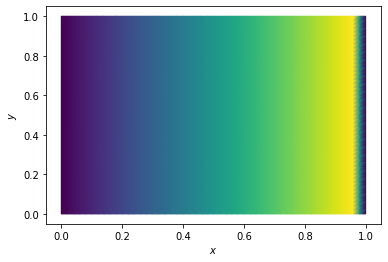

In [2]:
from firedrake import *
import matplotlib.pyplot as plt
from matplotlib import rc
import ufl

ufl.set_level(ufl.CRITICAL)

# Mesh definition
use_quad_mesh = True
number_of_elements_x = 25
number_of_elements_y = 25
mesh = UnitSquareMesh(number_of_elements_x, number_of_elements_y, quadrilateral=use_quad_mesh)

# Continuous Galerkin function space (degree = 1)
p = 1
V = FunctionSpace(mesh, "CG", p)
VelSpace = VectorFunctionSpace(mesh, "CG", p)

# Strong boundary conditions
u1, u2 = 0.0, 0.0
g_left = Constant(u1)
g_right = Constant(u2)

# Marking the boundaries
bc_left = DirichletBC(V, g_left, 1)
bc_right = DirichletBC(V, g_right, 2)
dirichlet_condition = [bc_left, bc_right]

# Source term
f = Constant(1)

# Getting trial and test functions
u = TrialFunction(V)
v = TestFunction(V)

# Model's parameters
k = Constant(1e-8)  # Diffusion
b = Function(VelSpace)
b.interpolate(as_vector([1.0, 0.0]))  # Advective velocity

# Bilinear form
a = k * inner(grad(v), grad(u))*dx + dot(b, grad(u)) * v * dx

# Linear form (RHS)
L = f * v * dx

# *** Adding residual stabilizing terms ***
# Stabilizing parameters (based on Franca et al. 1992)
if p == 1:
    m_k = 1.0 / 3.0
elif p == 2 and not use_quad_mesh:
    m_k = 1.0 / 12.
elif p == 2 and use_quad_mesh:
    m_k = 1.0 / 24.
else:
    raise ValueError("The employed mesh currently has no stabilization parameters available.")

# h_k = CellDiameter(mesh)
h_k = sqrt(2) * CellVolume(mesh) / CellDiameter(mesh)
# b_norm = norm(b)
b_norm = sqrt(dot(b, b))
Pe_k = m_k * b_norm * h_k / (2.0 * k)
one = Constant(1.0)
eps_k = conditional(gt(Pe_k, one), one, Pe_k)
tau_k = h_k / (2.0 * b_norm) * eps_k

# Residual stabilizing terms
a += inner((dot(b, grad(u)) - k*div(grad(u))), tau_k * dot(b, grad(v))) * dx
L += f * tau_k * dot(b, grad(v)) * dx

# Discretizing the variational problem
u_sol = Function(V)
problem = LinearVariationalProblem(a, L, u_sol, dirichlet_condition)

# Solving the discretized system
solver = LinearVariationalSolver(problem)
solver.solve()

# Writing solution to vtk file
output_pvd = File("result_supg/sol.pvd")
output_pvd.write(u_sol)

# Plotting the solution
tripcolor(u_sol)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()